In [38]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer


# 1. The LASSO and Boosting for Regression

## 1.(a) Download the Communities and Crime data

In [39]:
data_file = "../data/communities.data"
attr_file = "../data/communities.names"

In [40]:
# find attribute names from .names data
attrs = []
with open(attr_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if (line.startswith('@attribute')):
            attrs.append(line.split(" ")[1])

# print out the attributes' information 
print("There are", len(attrs), "attributes.")
print(attrs[:5], "are 5 non-predictive attributes that we should ignore")

There are 128 attributes.
['state', 'county', 'community', 'communityname', 'fold'] are 5 non-predictive attributes that we should ignore


In [41]:
commt_data = pd.read_csv(data_file, sep=",", header=None, names=attrs, na_values='?')
commt_data = commt_data.iloc[:, 5:]

## 1.(b) Use a data imputation technique to deal with the missing values in the data set. 

In [42]:
nan_info = commt_data.apply(lambda col : sum(col.isna()) / len(col), axis=0)
# drop the columns that missing values have propotion over 0.3
filtered_commt_data = commt_data.loc[:, nan_info.values < 0.3]
column_names = filtered_commt_data.columns

In [45]:

# imputate missing values with mean
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
filtered_commt_data = pd.DataFrame(impute.fit_transform(filtered_commt_data), 
                                   columns=filtered_commt_data.columns)
# split train dataset
train_set = filtered_commt_data.iloc[:1495, :]
test_set = filtered_commt_data.iloc[1495:, :]


## 1.(c) Plot a correlation matrix for the features in the data set.

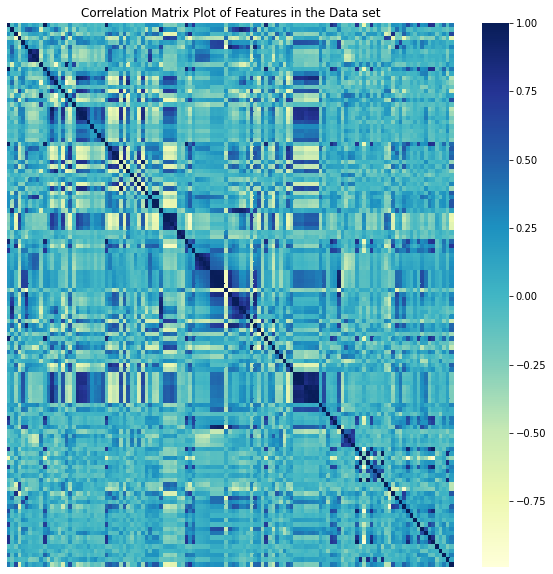

In [47]:
# correlation matrix
fit, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(commt_data.corr(),cmap="YlGnBu",xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix Plot of Features in the Data set")
plt.show()
plt.close()

## 1.(d) Calculate the Coefficient of Variation CV for each feature

In [90]:
coef_of_variation = commt_data.apply(lambda col : col.std() / col.mean(), axis=0)
coef_of_variation

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.306251
LemasGangUnitDeploy    0.921372
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.844368
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64

## 1.(e) Pick $\lfloor\sqrt{128}\rfloor$ features with highest CV, and make scatter plots and box plots for them.

In [91]:
num_features = int(np.sqrt(128))
highestCV = coef_of_variation.sort_values(ascending=False)[:num_features]
highestCV

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
LemasSwornFT           1.984599
PctPolicAsian          1.979371
HousVacant             1.958780
dtype: float64

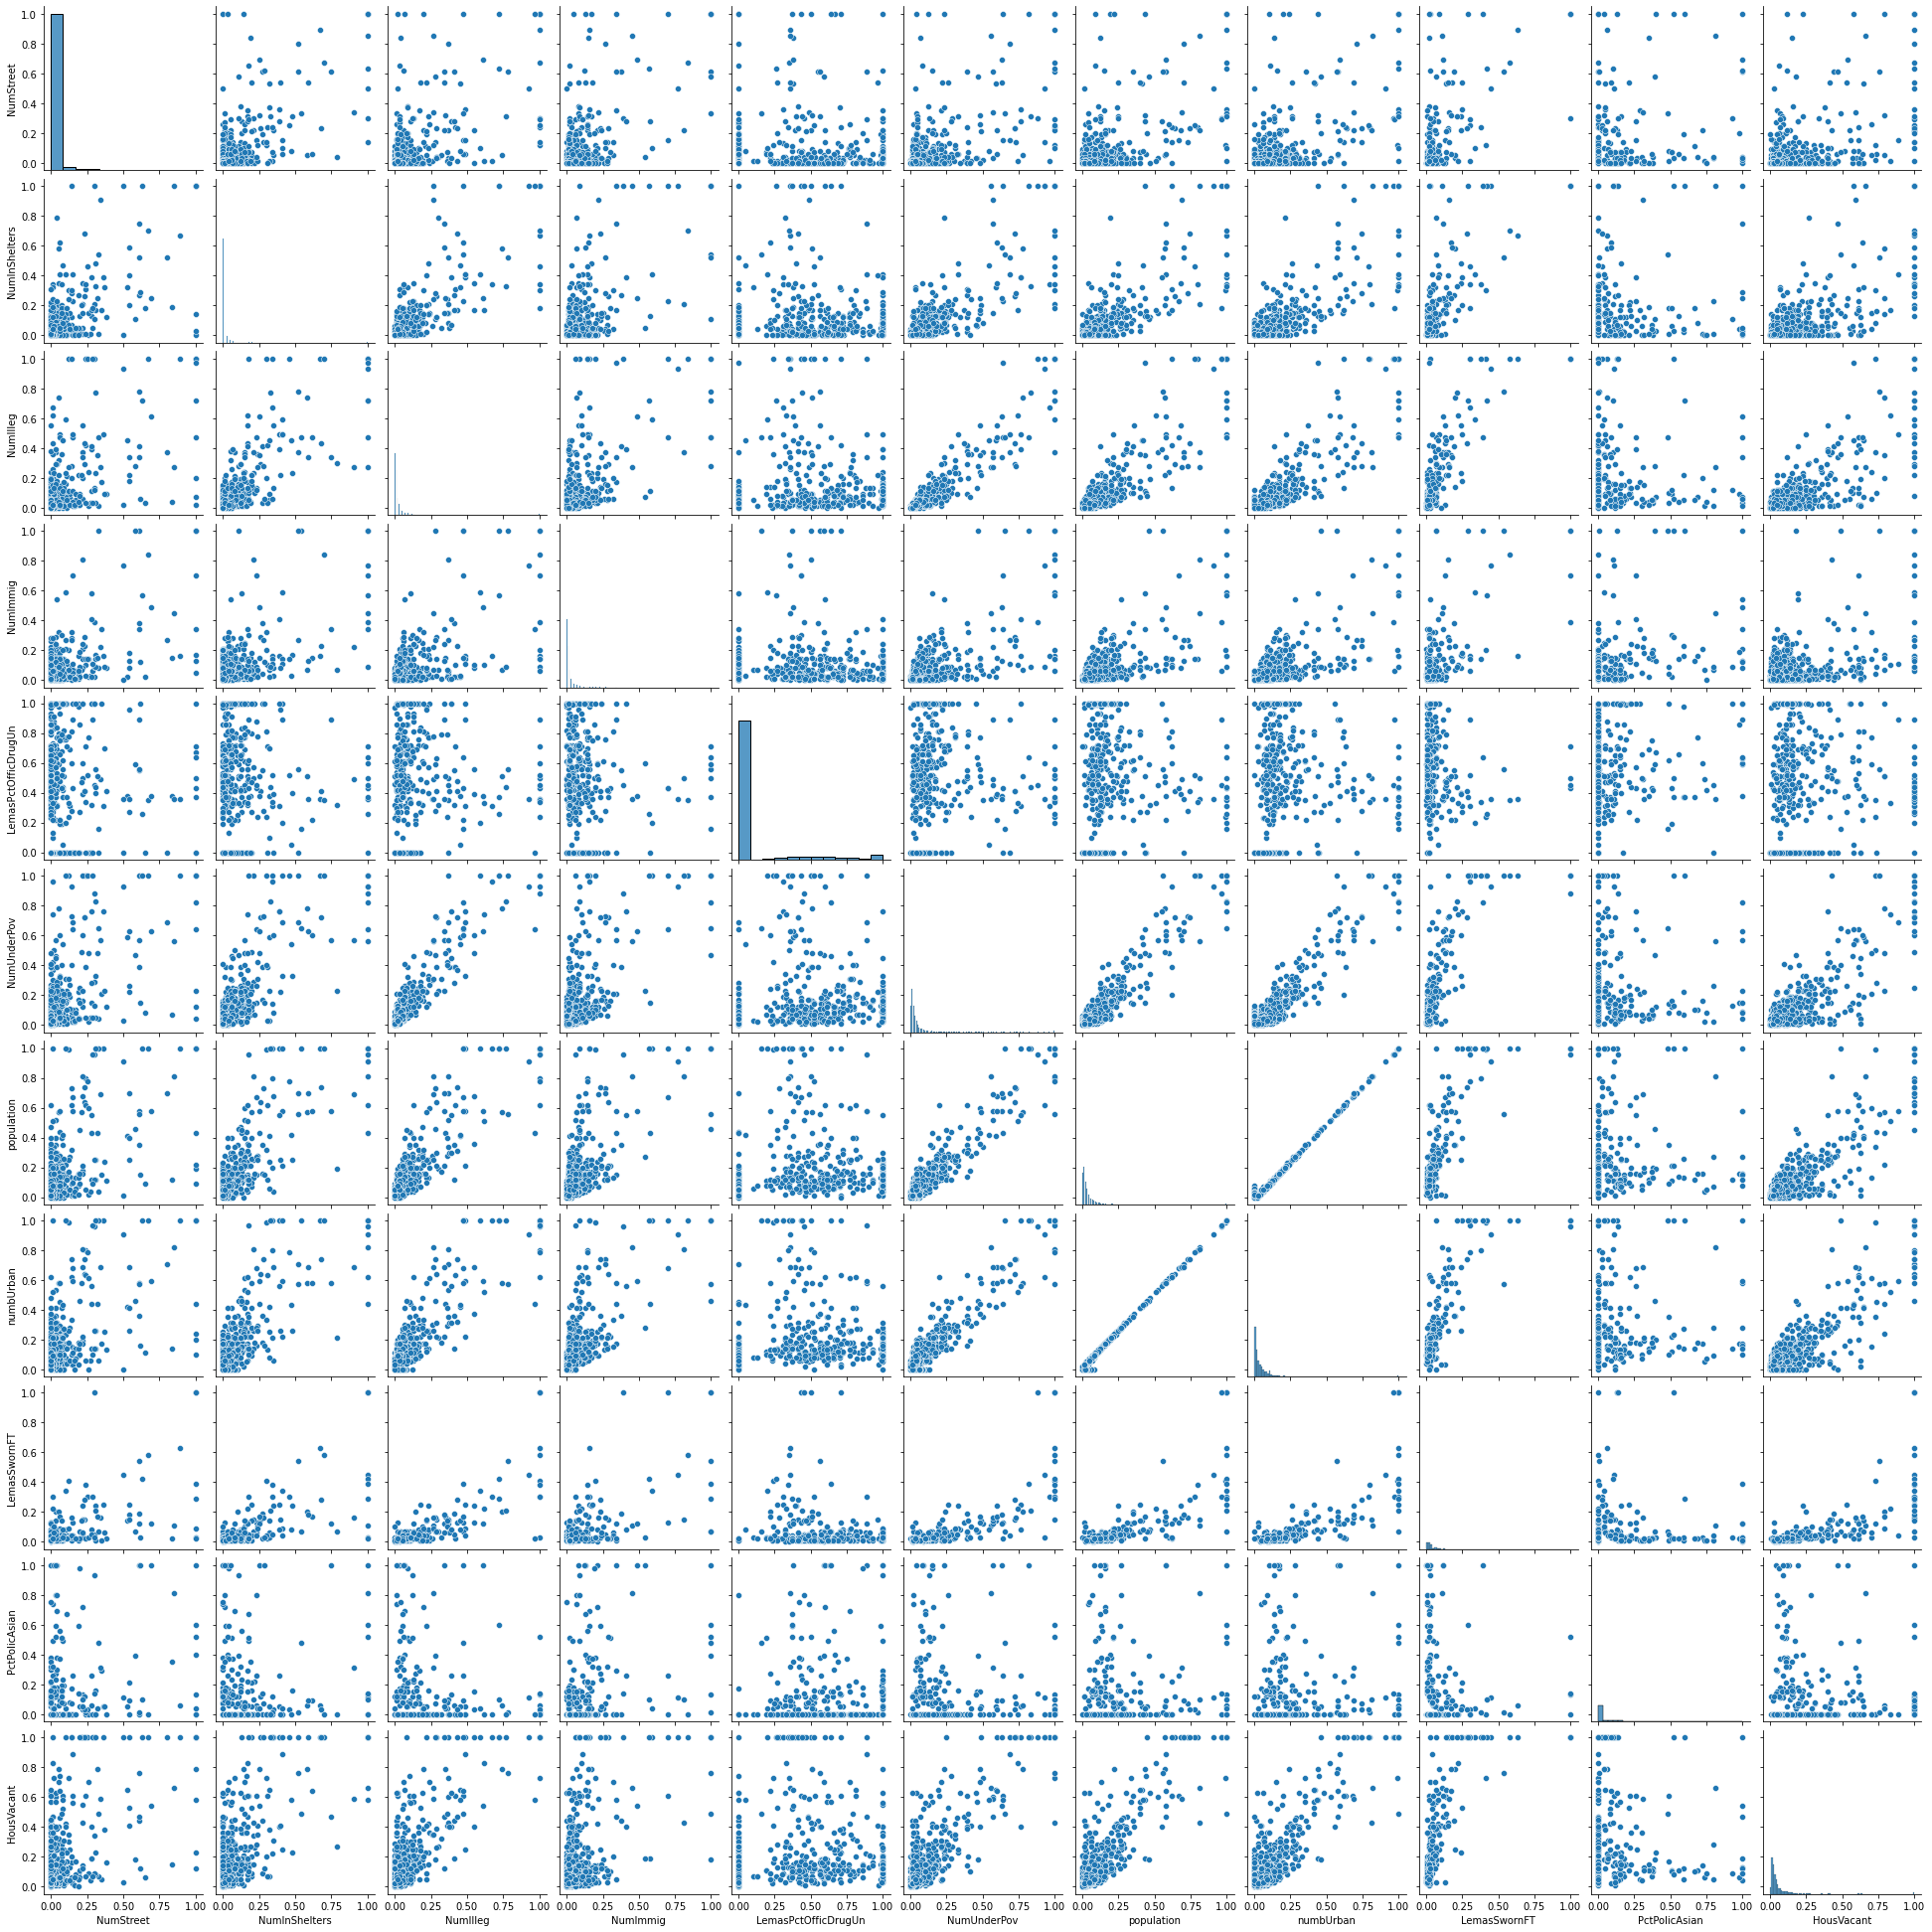

In [92]:
cols = highestCV.index.tolist()
sns.pairplot(commt_data[cols])
plt.show()
plt.close()

I can't draw conclusions about the significane of each feature by the scatter plots.

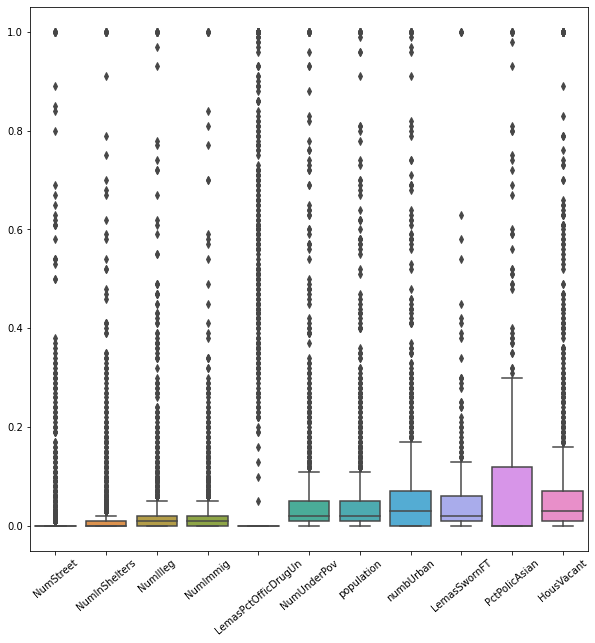

In [96]:
fig, axes = plt.subplots(figsize=(10,10))
sns.boxplot(data=commt_data[cols], ax=axes)
#make room for feautre names to be seen
plt.xticks(rotation=40)
plt.show()
plt.close()

## 1.(f) Fit a linear model using least squares to the training set and report the test error.

In [97]:
train_X = train_set.iloc[:, :-1]
train_Y = train_set.iloc[:, -1]

test_X = test_set.iloc[:, :-1]
test_Y = test_set.iloc[:, -1]


LR = LinearRegression()
LR.fit(train_X, train_Y)
test_pred = LR.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
print("Linear Regression's test MSE:", test_mse)

Linear Regression's test MSE: 0.017844644706157833


## 1.(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [99]:

# create k-fold cross validation splitter
splitter = KFold(5, shuffle=True, random_state=1234)

# create a list of alpha ooptions
param = [10 ** i for i in range(-2, 2)]

# create ridge model
ridge_model = RidgeCV(alphas=param, cv=splitter, 
                      scoring='neg_mean_squared_error')
ridge_model.fit(train_X, train_Y)
print("Best alpha = {}".format(ridge_model.alpha_))

Best alpha = 1.0


In [100]:
test_pred = ridge_model.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
#model_test_mse["Ridge_Regression"] = test_mse
print("Ridge Regression's test MSE:", test_mse)

Ridge Regression's test MSE: 0.017502306931091564


## 1.(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. 

In [104]:
from sklearn.linear_model import LassoCV
param = [10 ** i for i in range(-5, 3)]

# Lasso without standardization
lasso_model = LassoCV(alphas=param, cv=splitter)
lasso_model.fit(train_X, train_Y)
print("Best alpha = {}".format(lasso_model.alpha_))

Best alpha = 0.0001


In [105]:
test_pred = lasso_model.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["Lasso_w/o_std"] = test_mse
print("Without standardization, Lasso Regression's test MSE:", test_mse)
lasso_selecte_feature = pd.Series(data=lasso_model.coef_[lasso_model.coef_!=0],
                                  index=test_X.columns[lasso_model.coef_!=0])
print(lasso_selecte_feature)

Without standardization, Lasso Regression's test MSE: 0.01758385221993978
racepctblack           0.275387
racePctAsian          -0.014810
agePct12t21            0.078213
agePct12t29           -0.279285
agePct65up             0.011939
                         ...   
PctSameCity85          0.028100
LandArea               0.016662
PopDens                0.007536
PctUsePubTrans        -0.046075
LemasPctOfficDrugUn    0.009125
Length: 67, dtype: float64


In [106]:
from sklearn.preprocessing import StandardScaler

# Lasso with standardization
scaler = StandardScaler()
std_train_X = scaler.fit_transform(train_X)
std_test_X = scaler.fit_transform(test_X)

std_train_X = pd.DataFrame(data=std_train_X, columns=train_X.columns)
std_test_X = pd.DataFrame(data=std_test_X, columns=test_X.columns)

# re-fit
lasso_model = LassoCV(alphas=param, cv=splitter)
lasso_model.fit(std_train_X, train_Y)
print("Best alpha = {}".format(lasso_model.alpha_))

Best alpha = 0.001


In [107]:
test_pred = lasso_model.predict(std_test_X)
test_mse = mean_squared_error(test_Y, test_pred)
print("After standardization, Lasso Regression's test MSE:", test_mse)
lasso_selecte_feature = pd.Series(data=lasso_model.coef_[lasso_model.coef_!=0],
                                  index=test_X.columns[lasso_model.coef_!=0])
print(lasso_selecte_feature)

After standardization, Lasso Regression's test MSE: 0.017710939343910603
population              -0.001318
racepctblack             0.067537
agePct12t21              0.005808
agePct12t29             -0.027356
pctUrban                 0.015397
pctWWage                -0.009828
pctWFarmSelf             0.003414
pctWInvInc              -0.015813
pctWSocSec               0.005282
pctWPubAsst              0.003295
pctWRetire              -0.014889
whitePerCap             -0.004651
blackPerCap             -0.003123
indianPerCap            -0.005016
AsianPerCap              0.004814
OtherPerCap              0.003792
HispPerCap               0.002939
PctPopUnderPov          -0.021052
PctLess9thGrade         -0.000525
PctEmploy                0.015509
MalePctDivorce           0.016556
MalePctNevMarr           0.015150
FemalePctDiv            -0.001859
PctKids2Par             -0.041631
PctYoungKids2Par        -0.008787
PctTeen2Par             -0.000512
PctWorkMom              -0.020014
NumIlleg 

After standardized, the MSE increases 0.0002 

## 1.(i) Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation.

In [112]:
def own_PCRCV(train_X, train_Y, dim):
    valid_err = 0
    # create k-fold cross validation splitter
    splitter = KFold(5, shuffle=True, random_state=1234)
    for train_idx, valid_idx in splitter.split(train_X):
        # split train and validation set
        sp_trainX = train_X.iloc[train_idx, :]
        sp_trainY = train_Y.iloc[train_idx]
        sp_validX = train_X.iloc[valid_idx, :]
        sp_validY = train_Y.iloc[valid_idx]
        # perform PCA
        pca = PCA(n_components=dim).fit(sp_trainX)
        pca_train = pca.transform(sp_trainX)
        pca_valid = pca.transform(sp_validX)
        olsreg = LinearRegression()
        olsreg.fit(pca_train, sp_trainY)
        valid_pred = olsreg.predict(pca_valid)
        valid_mse = mean_squared_error(sp_validY, valid_pred)
        valid_err += valid_mse
    return valid_err / 5


PCR_valid_err = []
for i in range(1, len(train_X.columns) + 1):
    valid_err = own_PCRCV(train_X, train_Y, i)
    PCR_valid_err.append((i, valid_err))

PCR_valid_err.sort(key=lambda x: x[1])
print("When M = {}, the validation mse reach minimum as {}.".format(PCR_valid_err[0][0],
                                                               PCR_valid_err[0][1]))

When M = 82, the validation mse reach minimum as 0.019485701470024788.


In [117]:
# create a PCA model using best M
pca = PCA(n_components=82).fit(train_X)

# apply PCA to train and test set
pca_train = pca.transform(train_X)
pca_test = pca.transform(test_X)

# linear regression with PCA results
LR = LinearRegression().fit(pca_train, train_Y)
test_pred = LR.predict(pca_test)
test_mse = mean_squared_error(test_Y, test_pred)
print("PCR model's test MSE:", test_mse)

PCR model's test MSE: 0.01812440289190716


## 1.(j) Fit a boosting tree to the data

In [33]:
"""
Doc references:
https://xgboost.readthedocs.io/en/latest/get_started.html
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=dmatrix#xgboost.DMatrix
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv#xgboost.cv
https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
"""


In [114]:
# convert data to Data Matrix defiened in xgboost gramework
train_Dmatrix = xgb.DMatrix(data=train_X, label=train_Y)
test_Dmatrix = xgb.DMatrix(data=test_X)

valid_err = []
param = [10 ** i for i in range(-5,3)]

# create k-fold cross validation splitter
splitter = KFold(5, shuffle=True, random_state=12345)

# perform cross-validation to find best alpha
for alpha in param:
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", reg_alpha=alpha,reg_lambda = 0)
    cvres = cross_val_score(xgb_model, train_X, train_Y, cv=splitter, 
                            scoring="neg_mean_squared_error")
    valid_err.append((alpha, np.abs(cvres.mean())))

# sort the list and get the minimum validation error
valid_err.sort(key=lambda x: x[1])
print("When alpha = {}, the validation mse reaches minimum of {}.".format(valid_err[0][0],
                                                               valid_err[0][1]))

When alpha = 1, the validation mse reaches minimum of 0.022490644592263243.


In [118]:
# xgboost model with best alpha
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=1, reg_lambda = 0).fit(train_X, train_Y)
test_pred = xgb_model.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
print("XGBoost's test MSE:", test_mse)

XGBoost's test MSE: 0.017579514134614088


# 2. Tree-Based Methods

## 2.(a) Download the APS Failure data

In [48]:
aps_train_path = '../data/aps_failure_training_set.csv'
aps_test_path = '../data/aps_failure_test_set.csv'

aps_train = pd.read_csv(aps_train_path, skiprows=20, na_values = 'na')
aps_test = pd.read_csv(aps_test_path, skiprows=20, na_values = 'na')


In [49]:
aps_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


## 2.(b) Data Preparation

### 2.(b)-i Research what types of techniques are usually used for dealing with data with missing values

**Ans:** According to my research, there are mainly two types of imputation: _univariant_ and _multivariant_.

Univariant methods use a constant value to impute the missing values, such as mean, median, or most frequent while multivariant methods use an iterative fashion to estimate the value should be imputed.

The implementation of `IterativeImputer` in sklearn is inspired by the MICE in R package. It is the more sophisticated way of data imputation but much more time-consuming. Considering the time-consuming when using weka in later sections, here I simply use mean imputation to the dataset.


In [50]:
# split features and label
aps_train_X = aps_train.iloc[:, 1:]
aps_train_Y = aps_train.iloc[:, 0]
aps_test_X = aps_test.iloc[:, 1:]
aps_test_Y = aps_test.iloc[:, 0]

In [51]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# transform our datasets
aps_train_X = pd.DataFrame(imp.fit_transform(aps_train_X), columns=aps_train.columns[1:])
aps_test_X = pd.DataFrame(imp.fit_transform(aps_test_X), columns=aps_test.columns[1:])

### 2.(b)-ii For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.

In [52]:
# calculate variations
coef_of_variation = aps_train_X.apply(lambda col : np.abs(np.std(col) / np.mean(col)), axis=0)
highestCV = coef_of_variation.sort_values(ascending=False)[:170]
highestCV

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
             ...    
bo_000      0.462560
bp_000      0.425963
bq_000      0.399188
br_000      0.382666
cd_000      0.000000
Length: 170, dtype: float64

### 2.(b)-iii Plot a correlation matrix for your features using pandas or any other tool.

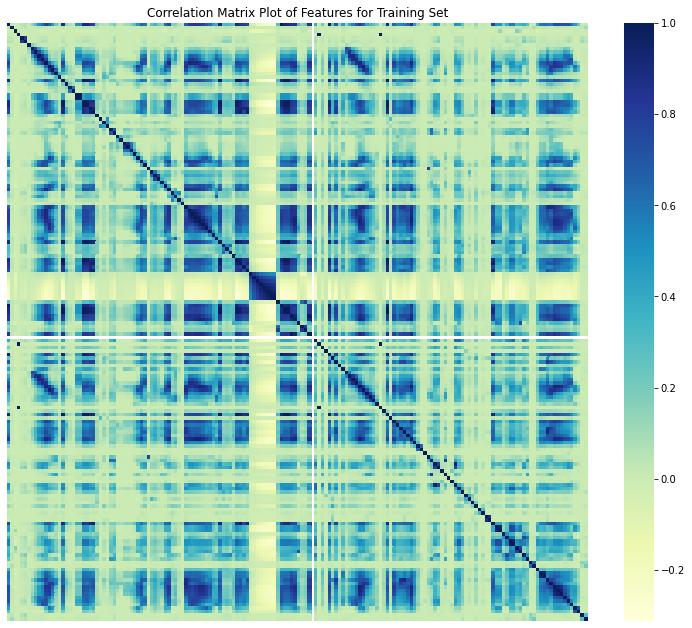

In [53]:
fit, axes = plt.subplots(figsize=(13,11 ))
sns.heatmap(aps_train_X.corr(), cmap="YlGnBu",
            xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix Plot of Features for Training Set")
plt.show()

### 2.(b)-iv Pick $\lfloor{ \sqrt{170} \rfloor}$ features with highest CV , and make scatter plots and box plots for them.

In [7]:
# set the number
num_new = int(np.sqrt(170))
highestCV = coef_of_variation.sort_values(ascending=False)[:num_new]
highestCV

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
dj_000    109.646371
ag_000     91.877799
as_000     86.416184
ay_009     83.785365
az_009     76.967337
ak_000     74.526067
au_000     68.159986
ch_000     58.267743
dtype: float64

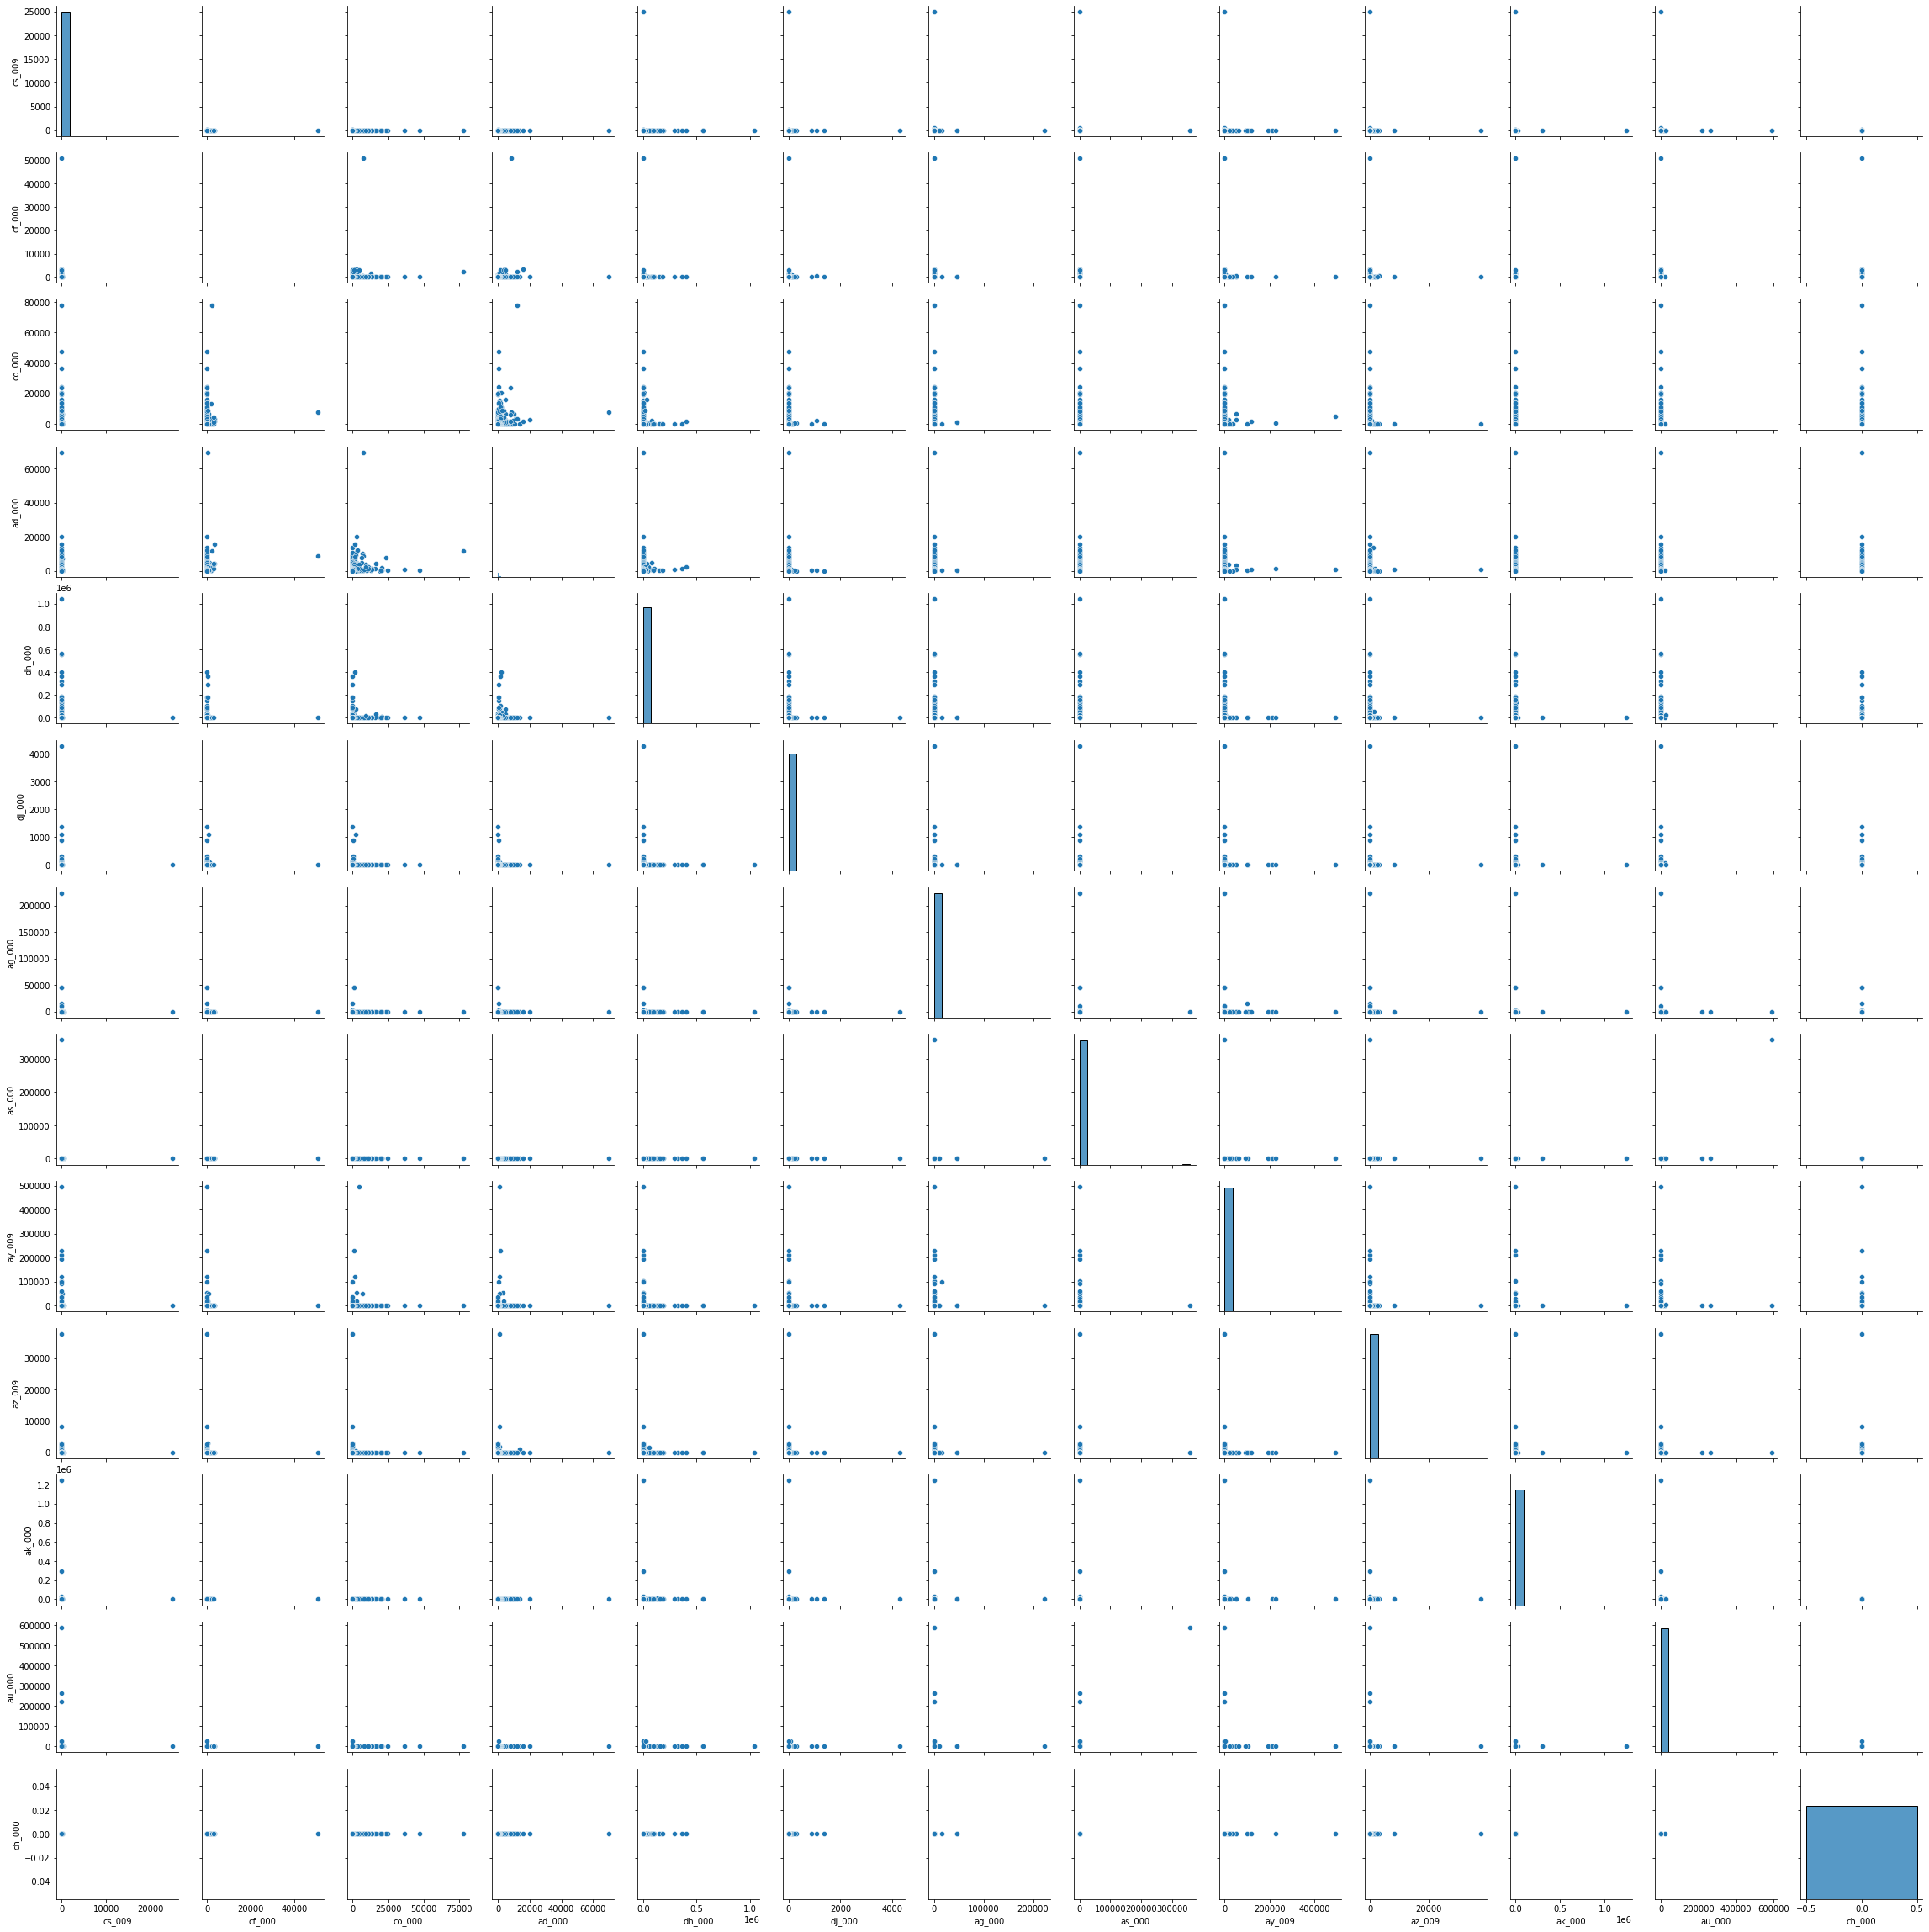

In [8]:
# here we sample 0.1 of the dataset beacuse it's too large that kills the kernel everytime
selected_cols = highestCV.index.tolist()
sns.pairplot(aps_train[selected_cols].sample(frac = 0.1))
plt.show()
plt.close()


In [13]:
selected_cols

['cs_009',
 'cf_000',
 'co_000',
 'ad_000',
 'dh_000',
 'dj_000',
 'ag_000',
 'as_000',
 'ay_009',
 'az_009',
 'ak_000',
 'au_000',
 'ch_000']

In [16]:
aps_train_X[selected_cols]

,cs_009,cf_000,co_000,ad_000,dh_000,dj_000,ag_000,as_000,ay_009,az_009,ak_000,au_000,ch_000
0,0.0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,190221.810984,190515.566938,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000443
2,0.0,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.000000,224.000000,186.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59996,0.0,2.000000,0.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59997,0.0,2.000000,0.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59998,0.0,2.000000,580.000000,494.000000,190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


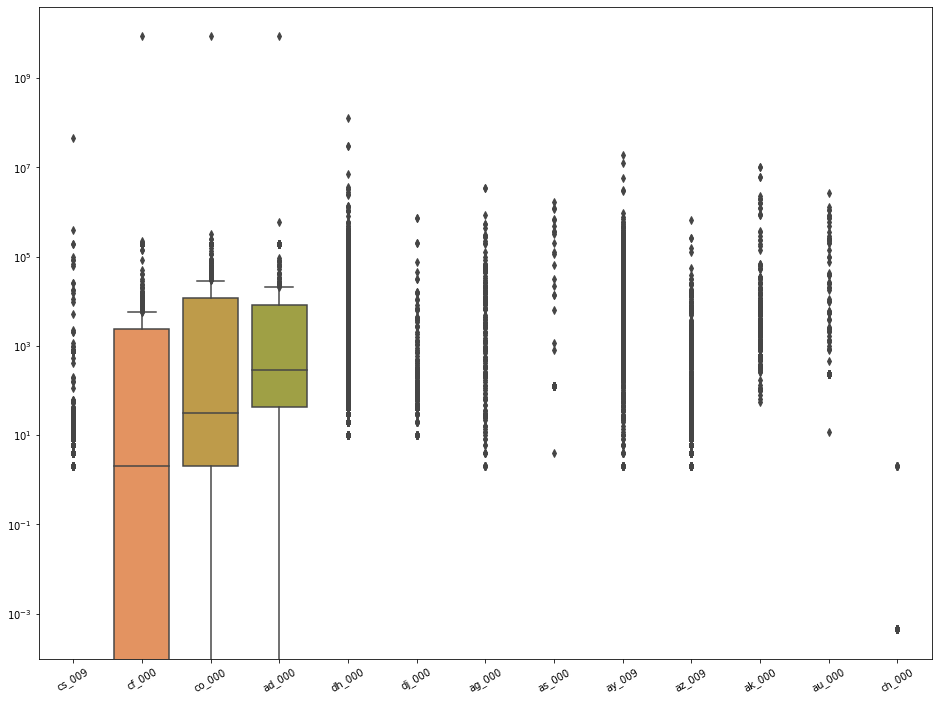

In [19]:
fig, axes = plt.subplots(figsize=(16, 12))
a = sns.boxplot(data=aps_train_X[selected_cols], ax=axes)
a.set(yscale = "log")
plt.xticks(rotation=30)
plt.show()
plt.close()


It is also hard to draw conclusions about significance of thess features

## 2.(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score

"""
Doc reference；
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
"""

# build random forest model
RF_model = RandomForestClassifier( 
                                  random_state=12345, 
                                  verbose=1, 
                                  oob_score=True)
RF_model.fit(aps_train_X, aps_train_Y)

# predict on dataset
train_Y_predict = RF_model.predict(aps_train_X)
train_Y_prob = RF_model.predict_proba(aps_train_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   50.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


The confusion for training set is 
[[59000     0]
 [    1   999]]
The classification accuracy is 1.0000


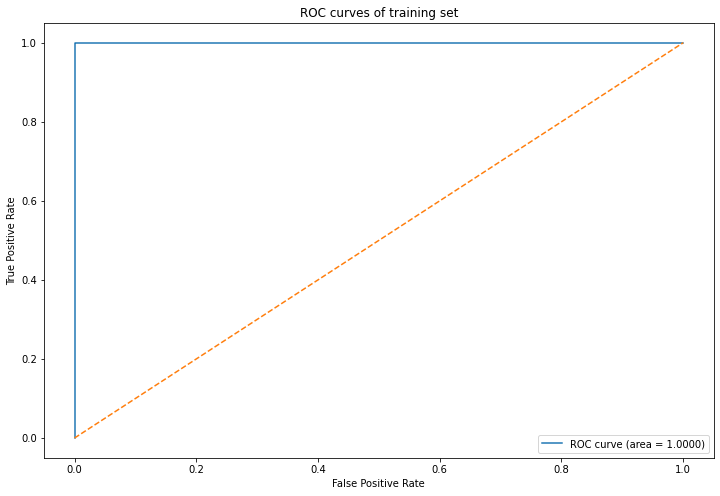

In [21]:
def model_plot(true_tag, predict, prob, title):
    conf_mat = confusion_matrix(true_tag, predict)
    print("The confusion for {} set is \n{}".format(title, conf_mat))
    acc = accuracy_score(true_tag, predict)
    print("The classification accuracy is %0.4f" % acc)
    fpr, tpr, thresholds = roc_curve(true_tag, prob[:, 1], pos_label='pos')
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(figsize=(12, 8))
    axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    axes.plot([0, 1], [0, 1], "--")
    axes.set_ylabel("True Positive Rate")
    axes.set_xlabel("False Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {} set".format(title))
    plt.show()
    plt.close()
    
#show info on training set    
model_plot(aps_train_Y, train_Y_predict, train_Y_prob, 'training')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


The confusion for test set is 
[[15608    17]
 [  102   273]]
The classification accuracy is 0.9926


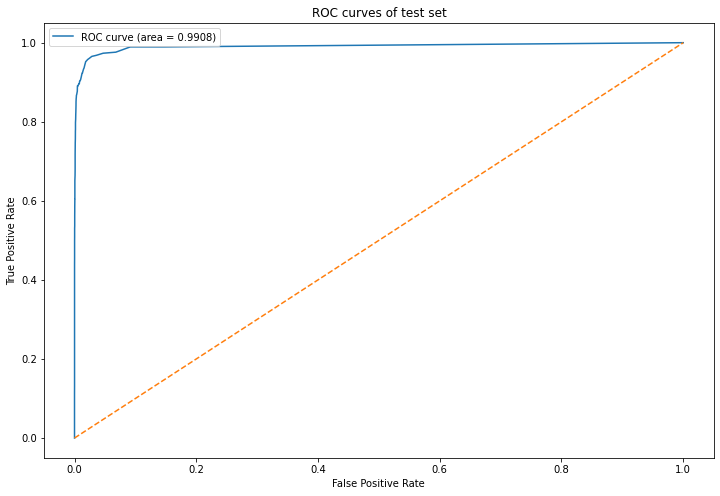

In [22]:
# predict on test dataset
test_Y_predict = RF_model.predict(aps_test_X)
test_Y_prob = RF_model.predict_proba(aps_test_X)

# get confusion matrix, ROC, AUC 
model_plot(aps_test_Y, test_Y_predict, test_Y_prob, 'test')

In [23]:
trainOOB_err = 1 - RF_model.oob_score_
print("The Out of Bag Error of training set is %.4f"%trainOOB_err)
print("The test Error is %.4f"%(1 - accuracy_score(aps_test_Y, test_Y_predict)))

The Out of Bag Error of training set is 0.0059
The test Error is 0.0074


## 2.(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


The confusion for training set is 
[[59000     0]
 [    0  1000]]
The classification accuracy is 1.0000


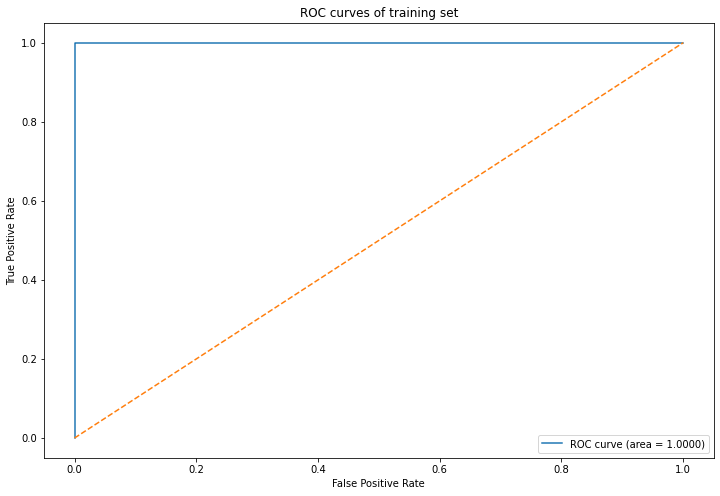

In [24]:
# build random forest model, balanced
RF_model = RandomForestClassifier(
                                  random_state=12345, 
                                  verbose=1, 
                                  oob_score=True,
                                  class_weight='balanced')
RF_model.fit(aps_train_X, aps_train_Y)

# predict on dataset
train_Y_predict = RF_model.predict(aps_train_X)
train_Y_prob = RF_model.predict_proba(aps_train_X)

# get confusion matrix, ROC, AUC 
model_plot(aps_train_Y, train_Y_predict, train_Y_prob, 'training')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


The confusion for test set is 
[[15615    10]
 [  161   214]]
The classification accuracy is 0.9893


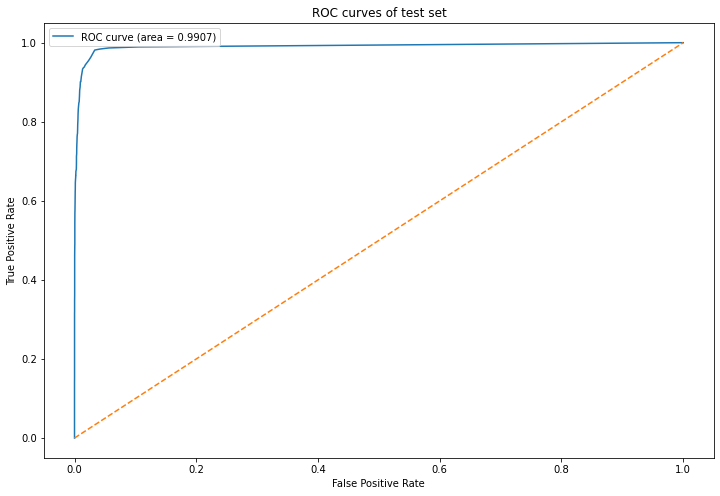

In [25]:
# predict on dataset
test_Y_predict = RF_model.predict(aps_test_X)
test_Y_prob = RF_model.predict_proba(aps_test_X)

model_plot(aps_test_Y, test_Y_predict, test_Y_prob, 'test')

In [27]:
#OOB Error
trainOOB_err = round(1 - RF_model.oob_score_, 4)
print("The Out of Bag Error of training set is %.4f"%trainOOB_err)
print("The test Error is %.4f"%(1 - accuracy_score(aps_test_Y, test_Y_predict)))

The Out of Bag Error of training set is 0.0080
The test Error is 0.0107


Comparing (c) and (d), both have 100% accuracy on training set and both of their test AUC area are the same and high. So (c) and (d)'s performance are same and both did well on this dataset.

## 2.(e) Model Trees using WEKA

In [43]:
# write new csv files for weka model to load
weka_train_path = '../data/weka_train.csv'
weka_test_path = '../data/weka_test.csv'

imputed_aps_train = aps_train_X.copy()
imputed_aps_train.loc[:, 'class'] = aps_train_Y
imputed_aps_test = aps_test_X.copy()
imputed_aps_test.loc[:, 'class'] = aps_test_Y

imputed_aps_train.to_csv(weka_train_path, index=False)
imputed_aps_test.to_csv(weka_test_path, index=False)

In [44]:
import weka.core.jvm as jvm
import javabridge
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [45]:
from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls

In [46]:
weka_loader = Loader(classname="weka.core.converters.CSVLoader")
weka_train = weka_loader.load_file(weka_train_path)
weka_test = weka_loader.load_file(weka_test_path)
weka_train.class_is_last()
weka_test.class_is_last()

In [47]:
# create LMT model and do 5-fold croos-validation
lmt = Classifier(classname='weka.classifiers.trees.LMT')
rs = Evaluation(weka_train)
rs.crossvalidate_model(classifier=lmt, data=weka_train, num_folds = 5, rnd=Random(60000))

In [48]:
#  training set confusion matrix
print(rs.confusion_matrix)

[[58823.   177.]
 [  304.   696.]]


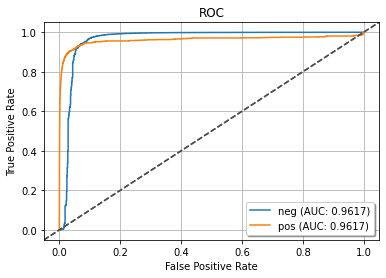

In [49]:
# plot training set ROC curve 
plcls.plot_roc(rs, class_index=[0, 1])

In [50]:
#training set summary
print(rs.summary())
print(rs.class_details())


Correctly Classified Instances       59519               99.1983 %
Incorrectly Classified Instances       481                0.8017 %
Kappa statistic                          0.7391
Mean absolute error                      0.011 
Root mean squared error                  0.0821
Relative absolute error                 33.5878 %
Root relative squared error             64.1084 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.304    0.995      0.997    0.996      0.741    0.962     0.998     neg
                 0.696    0.003    0.797      0.696    0.743      0.741    0.962     0.741     pos
Weighted Avg.    0.992    0.299    0.992      0.992    0.992      0.741    0.962     0.993     



In [51]:
lmt.build_classifier(weka_train)

weka_test_predict = []
weka_test_proba = []

# make prediction 
for inst in weka_test:
    weka_test_predict.append(lmt.classify_instance(inst))
    weka_test_proba.append(lmt.distribution_for_instance(inst))
# convert to numpy array
weka_test_predict = np.array(weka_test_predict).astype('str')
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_proba = np.array(weka_test_proba)

In [54]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score


The confusion matirx for test set is 
[[15579    46]
 [  108   267]]
The classification accuracy is 0.99038


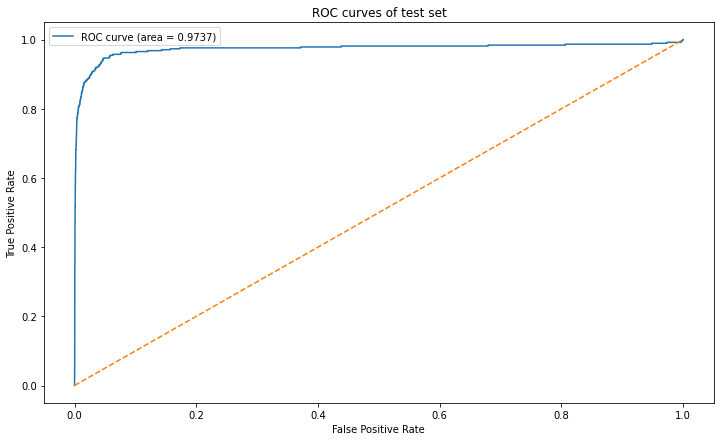

In [55]:
#test set 
model_plot(aps_test_Y, weka_test_predict, weka_test_proba, 'test')

So under 5 folds CV, training set's error is 0.008 test's error is 0.0096.

In [60]:
jvm.stop()

# 2.(f) is in a seperate notebook because I ran it on colab. Please check it in the other notebook

# 3. ISLR 6.6.3

**Ans:**

(a) **Steadily decrease.** As $s$ increase from 0, there is less restriction on $\beta$j, the model is more and more flexible so the training RSS will steadily decrease.

(b) **Decrease initially, and then eventually start increasing in a U shape.** As $s$ increases from 0, the model is more and more flexible and the test RSS will deacrease at first, but test RSS will increase since it is too flexible that leads to underfitting.

(c) **Steadily increase.**  There is almost no variance at the beginning stage. After the model becoming flexible, the variance will goe up.

(d) **Steadily decrease.** Bias decrease as the model is more flexible and perform better on training set so bias is decreasing.

(e) **Remain constant.** The irreducible erro is independent of the model.



# 4. I upload a image for this question please check image file.

# 5. ISLR 8.4.5

**Ans:**

With majority vote, X is RED since it occurs the most 6 reds vs 4 greens.

With the average probability, X is green since the average of 10 probabilities is smaller than 0.5.

# 6. ISLR 9.7.3

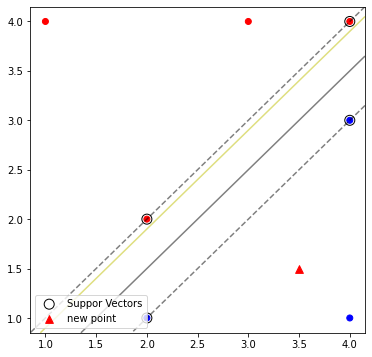

In [37]:
from sklearn.svm import SVC
data_dic = {'X1' : [3, 2, 4, 1, 2, 4, 4], 
           'X2' : [4, 2, 4, 4, 1, 3, 1], 
           'Y' : ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']}
data_df = pd.DataFrame.from_dict(data_dic)
clf = SVC(kernel='linear', C= 100)
clf.fit(data_df.iloc[:, :-1], data_df.iloc[:, -1])

# let's make a plot include all the questions
fig, ax = plt.subplots(figsize=(6, 6))

# scatter plot of sample points
ax.scatter(data_df.iloc[:, 0], data_df.iloc[:, 1], c=data_df.iloc[:, -1],
           cmap=plt.cm.Paired)

xlim = ax.get_xlim()
ylim = ax.get_ylim()


xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)


xy = np.vstack([XX.ravel(), YY.ravel()]).T
bd = clf.decision_function(xy).reshape(XX.shape)

# hyperplane
lines1 = ax.contour(XX, YY, bd, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label="Suppor Vectors")
#not optimal line
lines2 = ax.contour(XX, YY, bd - 0.8, colors='y', levels=[0], alpha=0.5,
           linestyles=['-'])


# none seperable point 
ax.scatter([3.5], [1.5], color='r', marker='^', s=60, label="new point")

ax.legend()
plt.show()
plt.close()

(b) The solid black line is the hyperplane.
And the optimal seperating hyperlane is between (2,1),(2,2) and (4,3), (4,4). So the line go through (2,1.5), (4,3.5) and the equation is 

X1-X2 - 0.5 = 0

(c) We can see, the parameters are approximately:

If X1-X2-0.5 <0 THEN red ; IF X1-X2-0.5>0, THEN blue
$\beta$0 = -0.5,$\beta$1 = 1,$\beta$2 = -1

(d) The dash lines are the maximal margin.

(e) The circeled ones that lie on the dash lines are support vectors.
(2,1),(2,2),(4,3),(4,4)

(f) The seventh point is not a support vector so I won't effect the maximal margin hyperplane.

(g) The solid yellow line.

(h) The new point (3.5,1.5) marked as red triangle. This make the two classes not seperable by a hyperplane.